# Проект "Анализ игр"

## Описание и задачи проекта

  У нас есть данные об играх: продажи, оценки пользователей и экспертов, жанры, платформы. Необходимо выяснить, что влияет на успешность игры и на основе выводов спланировать кампаниб продаж на следующий год.

### План проекта:
- Изучение общей информации;
- Подготовка данных к исследованию;
- Исслеовательский анализ данных;
- Формирование портрета пользователя каждого региона;
- Проверка гипотез;
- Формулирование общего вывода.

## Шаг 1. Изучение общей информации

- Импортируем все необходимые для работы библиотеки;
- Импортируем файл с данными;
- Исследуем файл на предмет наличия пропусков и правильности типа данных с помощью метода info(), также посмотрим, что из себя представляют данные с помощью метода sample().

In [2]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np
from pymystem3 import Mystem 
m = Mystem()
from collections import Counter
import warnings
warnings.filterwarnings("ignore")
from matplotlib.ticker import MaxNLocator
import math
from scipy.stats import ttest_ind
from scipy import stats as st
from IPython.display import display

In [3]:
data = pd.read_csv('/datasets/games.csv')
pd.set_option('display.max_columns', 100)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [5]:
data.sample(5)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
9773,NCIS,PS3,2011.0,Adventure,0.07,0.04,0.00,0.02,50.0,4,T
10638,Virtual Pool 64,N64,1998.0,Sports,0.08,0.02,0.00,0.00,NaN,NaN,NaN
7415,Heroes of Ruin,3DS,2012.0,Role-Playing,0.13,0.07,0.00,0.02,69.0,7.4,T
9426,Destruction Derby Arenas,PS2,2004.0,Racing,0.06,0.05,0.00,0.02,57.0,7.8,T
725,Teenage Mutant Ninja Turtles II: The Arcade Game,NES,1990.0,Action,1.74,0.25,0.21,0.03,NaN,NaN,NaN


#### Вывод 1 шага:
1. Необходимо изменить тип переменных:
 - Year_of_Release на int64;
 - User_Score на float64 
2. Были обнаружены пропуски в столбцах:
 - Name. В этом столбце всего 2 пропуска, будем считать, что они полностью случайны и являются какой-то ошибкой.
 - Year_of_Release. В этом столбце меньше 300 пропусков - очень немного. Возможно, эти игры еще не вышли.
 - Genre. В этом столбце всего 2 пропуска, будем считать, что они полностью случайны и являются какой-то ошибкой.
 - Critic_Score. В этом столбце больше половины значений пропущены. Возможно, потому что эти игры не оценивали критики.
 - User_Score. В этом столбце больше 6000 пропусков. Возможно, потому что эти игры не оценил ни один из пользователей.
 - Rating. В этом столбце больше 6000 пропусков. Возможно, потому что эти игры не оценивала организация ESRB.
3. Категориальные переменные записаны буквами в разных регистрах. Чтобы исключить возможность ошибки в написании таких данных, необходимо будет перевести все в строчный регистр.
4. Названия столбцов записаны в 2х регистрах. Для упрощения работы с данными необходимо будет перевести их в строчный регистр.
5. Оценки критиков и оценки пользователей представлены в разных шкалах. При обработке данных приведем их к одной - 100-балльной шкале.

# Шаг 2. Подготовка данных к исследованию

### I. Приведем данные к одному регистру.

В первую очередь приведем к нижнему регистру наименования столбцов. Это сильно упростит нам работу с данными.

In [6]:
data.columns = data.columns.str.lower()

Далее приведем к нижнему регистру все столбцы с категориальными переменными. Это необходимо сделать, так как одна и та же игра/платформа/жанр может быть записана по-разному в зависимости от выбранного регистра. 

In [7]:
data['name'] = data['name'].str.lower()

In [8]:
data['platform'] = data['platform'].str.lower()

In [9]:
data['genre'] = data['genre'].str.lower()

### II. Приведем данные к нужным типам.

Данные о годе выпуски игры сделаем целочисленными

In [10]:
data['year_of_release'] = data['year_of_release'].astype('Int64')

Данные о пользовательском рейтинге нам необходимо привести к типу float, но мы не можем этого сделать сразу, так как в этом столбце у нас есть игры с рейтингом 'tbd'. Эта аббревеатура расшифровывается как 'to be determind', то есть 'будет определено'. Посмотрим на строки с такими данными и рушим, что с ними делать.

In [11]:
data.query('user_score == "tbd"').sample(10)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
15294,azada,3ds,2012,puzzle,0.00,0.02,0.0,0.00,NaN,tbd,E
7311,petz rescue: wildlife vet,wii,2008,simulation,0.20,0.00,0.0,0.02,NaN,tbd,E
12182,fifa soccer 06,gba,2005,sports,0.05,0.02,0.0,0.00,NaN,tbd,E
5207,shaun palmer's pro snowboarder,gba,2001,sports,0.26,0.10,0.0,0.01,58.0,tbd,E
3314,madden nfl 2002,gc,2001,sports,0.47,0.12,0.0,0.02,89.0,tbd,E
6146,hannah montana: spotlight world tour,ps2,2008,action,0.12,0.02,0.0,0.14,NaN,tbd,E
6376,littlest pet shop: beach friends,ds,2009,simulation,0.25,0.00,0.0,0.02,NaN,tbd,E
10267,hole in the wall: deluxe edition,x360,2011,misc,0.10,0.00,0.0,0.01,NaN,tbd,E
1300,midway arcade treasures,ps2,2003,misc,0.72,0.56,0.0,0.19,76.0,tbd,T
4297,nickelodeon team umizoomi,ds,2011,action,0.42,0.00,0.0,0.03,NaN,tbd,EC


In [12]:
len(data.query('user_score == "tbd"'))

2424

Видим, что таких строк у нас 2424 и что данные о продажах у этих игр есть. Будем считать, что рейтинг заполняется этой аббревеатурой в том случае, если пользовательских отзывов слишком мало, и он еще не определен. То есть по сути, это пропущенные значения. Поэтому заменим данные о рейтинге с аббревеатурой 'tbd' на Nan.

In [13]:
data['user_score'] = data['user_score'].str.replace('tbd', 'NaN')

Теперь приведем данные к типу float.

In [14]:
data['user_score'] = data['user_score'].astype('Float64')

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
name               16713 non-null object
platform           16715 non-null object
year_of_release    16446 non-null Int64
genre              16713 non-null object
na_sales           16715 non-null float64
eu_sales           16715 non-null float64
jp_sales           16715 non-null float64
other_sales        16715 non-null float64
critic_score       8137 non-null float64
user_score         7590 non-null float64
rating             9949 non-null object
dtypes: Int64(1), float64(6), object(4)
memory usage: 1.4+ MB


Приведем рейтинг пользователей и критиков к одной системе - 100-балльной. 

In [16]:
data['user_score'] = data['user_score'] * 10

### III. Обработаем пропуски в данных.

Сначала рассмотрим столбцы, в которых мы обнаружили по 2 пропуска - name и genre.

In [17]:
data[data['name'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,gen,1993,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,gen,1993,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Видим, что кроме имени в этих строках пропущены данные о жанре и рейтинге. У одной игры почти нет продаж, а у другой продажи большие, но мы не сможем ее проанализировать, так как у нас не хватает данных для этого. Поэтому удалим две этих строки.

In [18]:
data.dropna(subset=['name'], inplace=True)

In [19]:
data['name'].isna().sum() # проверила

0

Далее рассмотрим пропуски в столбце с годом релиза игры. Их всего 246 - это маленькое количество. Исходя из того, что мы не сможем точно определить год выхода игры на основании имеющихся данных, оставим эти пропуски. Возможно, мы бы могли заполнить пропуски для тех игр, для которых указан год релиза на других платформах, но это тоже будет очень неточно - на одной платформе игра может выйти в 2010 году, а на другой - в 2012. И тогда мы заполним пропуски неправильно.

Пропуски в всех столбцах с рейтингом оставим, так как причиной из возникновения могло быть то, что эти игры не оценивали критики, пользователи, организация ESRB - либо все вместе, либо по-отдельности. Бывают непопулярные или инди-игры для маленькой аудитории и до них просто "не добираются" критики, а пользователей немного, значит, такие игры могут остаться без оценок. 
возможный вариант заполнения пропусков - средней или медианной оценкой игры для других платформ. Но это будет неточное заполнение - у некоторых игр на разных платформах рейтинг может отличаться. Дело в том, что разные платформы популярны в разных странах. И в этих странах живут разные люди и критики, по-разному оценивающие игры. Например, у игры, выпущенной на консоли Nintendo рейтинг может быть больше или меньше, чем у той же игры, выпущенной на консоли Xbox, так как Nintendo популярна в Японии, а Xbox - в США. 
Также, ориентируясь на срез данных из таблицы ниже, мы можем увидеть, что, например, у игры Zumba fitness значительно отличаются пользовательские рейтинги на платформах Xbox и Playstation.

In [20]:
data.sort_values(by='name').tail(50)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
15254,zillions of enemy x: zetsukai no crusade,ps3,2013,role-playing,0.00,0.00,0.02,0.00,NaN,NaN,NaN
14536,zoboomafoo: leapin' lemurs!,ps,2001,action,0.02,0.01,0.00,0.00,NaN,NaN,NaN
15925,zoey 101: field trip fiasco,ds,2007,action,0.02,0.00,0.00,0.00,31.0,NaN,E
11101,zoids assault,x360,2007,strategy,0.08,0.00,0.00,0.01,46.0,73.0,T
15819,zoids dash,ds,2006,role-playing,0.00,0.00,0.02,0.00,NaN,NaN,NaN
8808,zoids: battle legends,gc,2003,action,0.12,0.03,0.00,0.00,NaN,81.0,T
11323,zoids: legacy,gba,2003,role-playing,0.06,0.02,0.00,0.00,NaN,89.0,E
13649,zombi daisuki,ds,2011,action,0.00,0.00,0.04,0.00,NaN,NaN,NaN
7539,zombie army trilogy,ps4,2015,shooter,0.05,0.12,0.00,0.03,62.0,68.0,NaN
10316,zombie army trilogy,xone,2015,shooter,0.05,0.05,0.00,0.01,62.0,72.0,NaN


### IV. Посчитаем суммарные продажи во всех регионах и запишите их в отдельный столбец.

In [21]:
data['total_sales'] = data['na_sales'] + data['jp_sales'] + data['eu_sales'] + data['other_sales']

### Вывод 2 шага:
- мы оставили все пропуски в данных, так как не имеем достаточного количества информации для их заполнения;
- пропусков в данных об оценках и рейтинге очень много. Это повод задуматься о корректности выгрузки данных.

# Шаг 3. Исследовательский анализ данных.

#### 1. Посмотрим, сколько игр выпускалось в разные годы. Ответим на вопрос "Важны ли данные за все периоды?".

Сгруппируем данные по году выпуска игры.

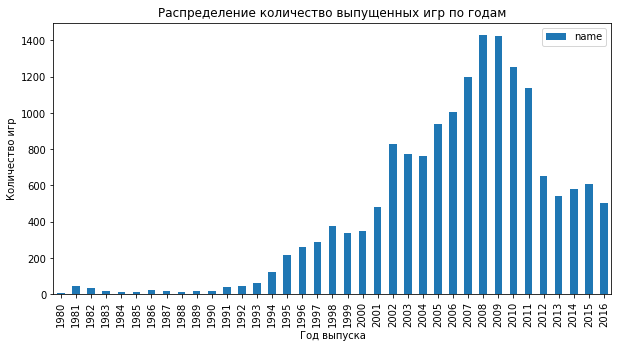

In [22]:
ax = (data.pivot_table(index='year_of_release', values='name', aggfunc='count')
 .plot(kind='bar', y='name', figsize=(10,5), title='Распределение количество выпущенных игр по годам'))
ax.set_xlabel('Год выпуска');
ax.set_ylabel('Количество игр');

Видим, что:
- до 1994 года выпускалось очень мало игр;
- в 2002 году был резкий скачок в производстве игр и до 2009 года количество выпускаемых игр практически всегда росло;
- в 2010 году начался спад в производстве игр и продолжался он до 2016 года.
- в период 2012-2016 год продажи игр значительно упали по сравнению с предшествующим 4-летним периодом.

#### 2. Посмотрим, как менялись продажи по платформам. Выберем платформы с наибольшими суммарными продажами и построим распределение по годам. Определим, за какой характерный срок появляются новые и исчезают старые платформы.

Построим график общих продаж по платформам и годам. 

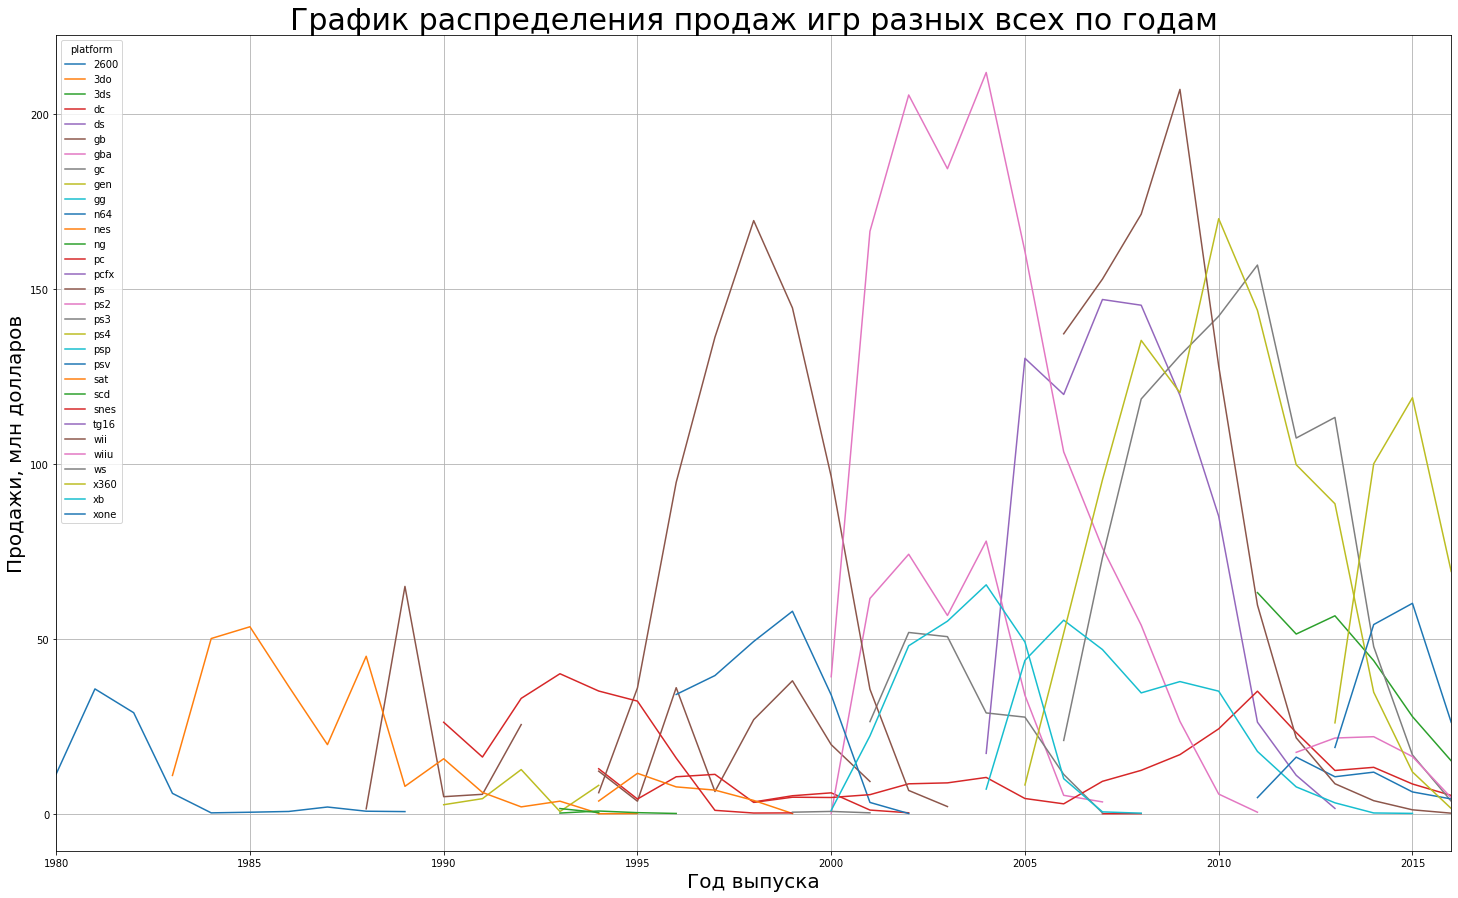

In [23]:
fig, ax=plt.subplots(figsize=(25,15))
data.pivot_table(index='year_of_release',
                columns='platform', 
                values='total_sales', 
                aggfunc='sum').plot(grid=True, ax=ax)
ax.set_xlabel('Год выпуска', fontsize = 20);
ax.set_ylabel('Продажи, млн долларов', fontsize = 20);
ax.set_title('График распределения продаж игр разных всех по годам', fontsize = 30);
plt.show()

Посмотрим, какие платформы являеются лидерами по продажам.

In [24]:
data.pivot_table(index='platform', values='total_sales', aggfunc='sum').sort_values(by='total_sales', ascending=False)

,total_sales
platform,
ps2,1255.77
x360,971.42
ps3,939.65
wii,907.51
ds,806.12
ps,730.86
gba,317.85
ps4,314.14
psp,294.05


Видим, что лидерами являются 6 платформ, начиная с 7й строчки сумма продаж меньше в 2 раза. Выделим их в отдельный датафрейм.

In [25]:
top_6_platform = (data.pivot_table(index='platform', values='total_sales', aggfunc='sum')
                  .sort_values(by='total_sales', ascending=False)
                 .head(6))
top_6_platform

,total_sales
platform,
ps2,1255.77
x360,971.42
ps3,939.65
wii,907.51
ds,806.12
ps,730.86


Выберем из общего датафрейма данные только об этих 6ти платформах.

In [26]:
top_6_platform_data = data.query('platform in @top_6_platform.index')
display(top_6_platform_data)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,wii sports,wii,2006,sports,41.36,28.96,3.77,8.45,76.0,80.0,E,82.54
2,mario kart wii,wii,2008,racing,15.68,12.76,3.79,3.29,82.0,83.0,E,35.52
3,wii sports resort,wii,2009,sports,15.61,10.93,3.28,2.95,80.0,80.0,E,32.77
6,new super mario bros.,ds,2006,platform,11.28,9.14,6.50,2.88,89.0,85.0,E,29.80
7,wii play,wii,2006,misc,13.96,9.18,2.93,2.84,58.0,66.0,E,28.91
...,...,...,...,...,...,...,...,...,...,...,...,...
16700,mezase!! tsuri master ds,ds,2009,sports,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01
16704,plushees,ds,2008,simulation,0.01,0.00,0.00,0.00,NaN,NaN,E,0.01
16709,score international baja 1000: the official game,ps2,2008,racing,0.00,0.00,0.00,0.00,NaN,NaN,NaN,0.00
16710,samurai warriors: sanada maru,ps3,2016,action,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01


Видим, что в датафрейме 9422 строки, что составляет почти 60% от изначального датафрейма. Будем считать, что приняли правильное решение, выбрав 6 платформ из всех.

Построим график распределения продаж топ-6 платформ по годам.

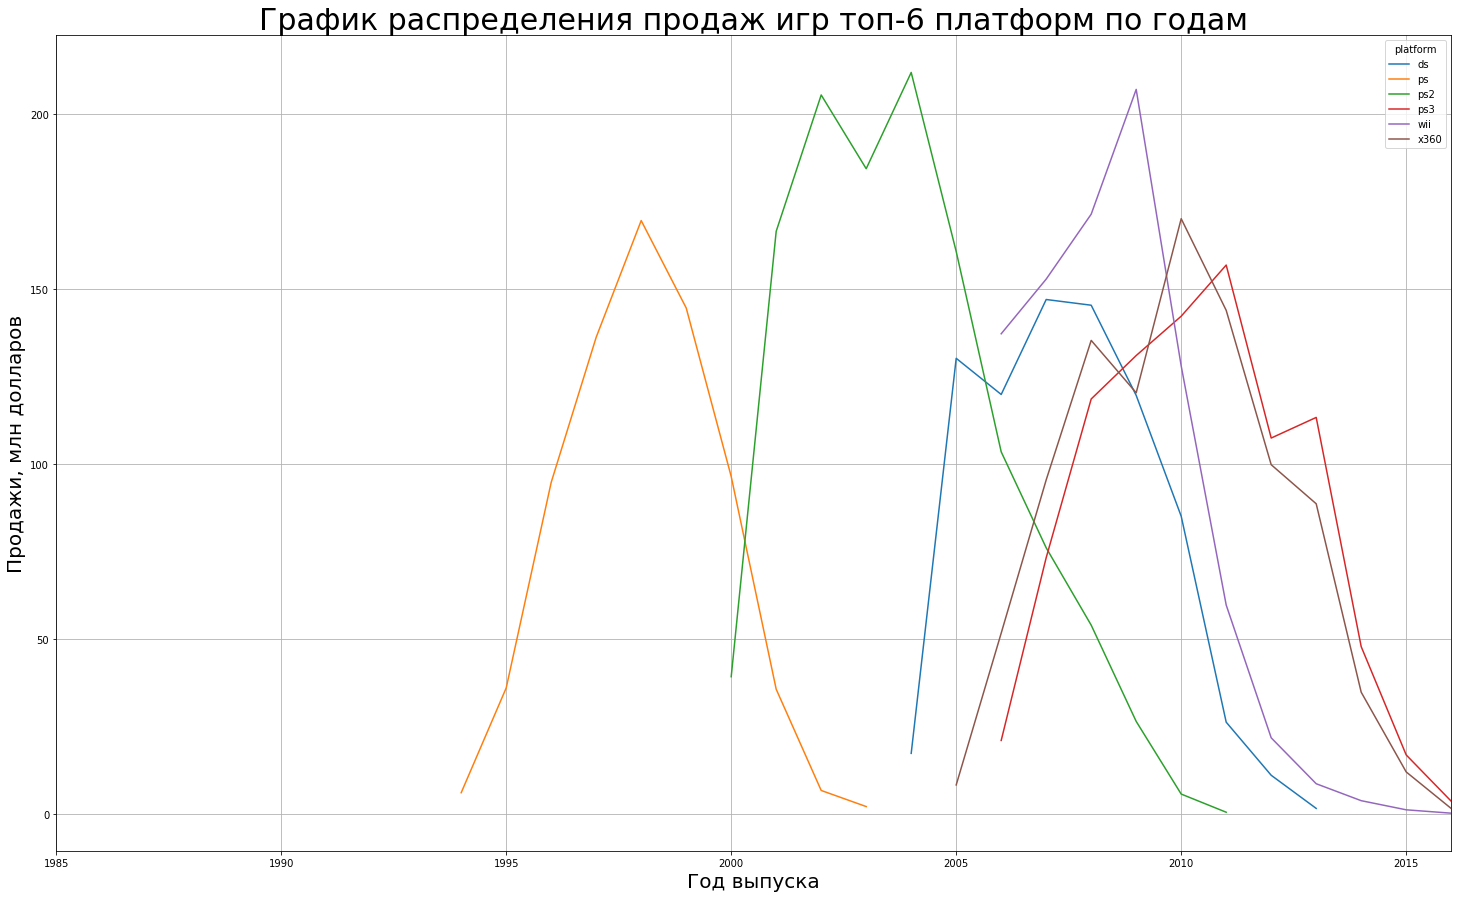

In [27]:
fig, ax=plt.subplots(figsize=(25,15))
top_6_platform_data.pivot_table(index='year_of_release',
                                columns='platform', 
                                values='total_sales', 
                                aggfunc='sum').plot(grid=True, ax=ax)
ax.set_xlabel('Год выпуска', fontsize = 20);
ax.set_ylabel('Продажи, млн долларов', fontsize = 20);
ax.set_title('График распределения продаж игр топ-6 платформ по годам', fontsize = 30);
plt.show()

Видим, что средняя продолжительность "жизни" платформы - 10 лет. Распределение продаж практически по всем платформам похоже на нормальное - первую половину "жизни" продажи растут, вторую - падают. Исключение - платформа wii - она стартовала с большой цифры продаж. Возможно, большое количество людей сделало предзазак этой платформы. Также видим, что в период с 2004 по 2006 год появились 4 платформы из топ-6 и все они развивались в приблизительно одинаковом темпе.

#### 3. Определим актуальный период для построения прогноза на 2017 год.

Мы видим, что в 4 из 6 топ-платформ были актуальными в период с 2004 по 2006 год. Но к 2016 году их продажи практически сошли на нет. Также мы видим, что в 2016 году значимые продажи показывали только 3 консоли - ps4, xone и psp. Кроме этого, заметим, что продажи игр в период 2002-2011 год были значительно больше, чем в период 2012-2016 год. А ранее 2002 года - наоборот, значительно меньше. Исходя из перечисленных фактов, за актуалый период возьмем 2013-2016 год, так как в 2013 году вышли платформы лидеры ps4 и xone. Будем считать данные по этим платформам наибоее важными для анализа. Выделим их в отдельный датафрейм, с которым продолжим работать.

In [28]:
relevant_data = data.query('year_of_release >= 2013')
relevant_data

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
16,grand theft auto v,ps3,2013,action,7.02,9.09,0.98,3.96,97.0,82.0,M,21.05
23,grand theft auto v,x360,2013,action,9.66,5.14,0.06,1.41,97.0,81.0,M,16.27
31,call of duty: black ops 3,ps4,2015,shooter,6.03,5.86,0.36,2.38,NaN,NaN,NaN,14.63
33,pokemon x/pokemon y,3ds,2013,role-playing,5.28,4.19,4.35,0.78,NaN,NaN,NaN,14.60
42,grand theft auto v,ps4,2014,action,3.96,6.31,0.38,1.97,97.0,83.0,M,12.62
...,...,...,...,...,...,...,...,...,...,...,...,...
16703,strawberry nauts,psv,2016,adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01
16707,aiyoku no eustia,psv,2014,misc,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01
16710,samurai warriors: sanada maru,ps3,2016,action,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01
16712,haitaka no psychedelica,psv,2016,adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01


#### 4. Исследуем, какие платформы лидируют по продажам, растут или падают. Выберем несколько потенциально прибыльных платформ.

Построим график распределения продаж по годам. Также с помощью сводной таблицы выделим наиболее прибыльные платформы.

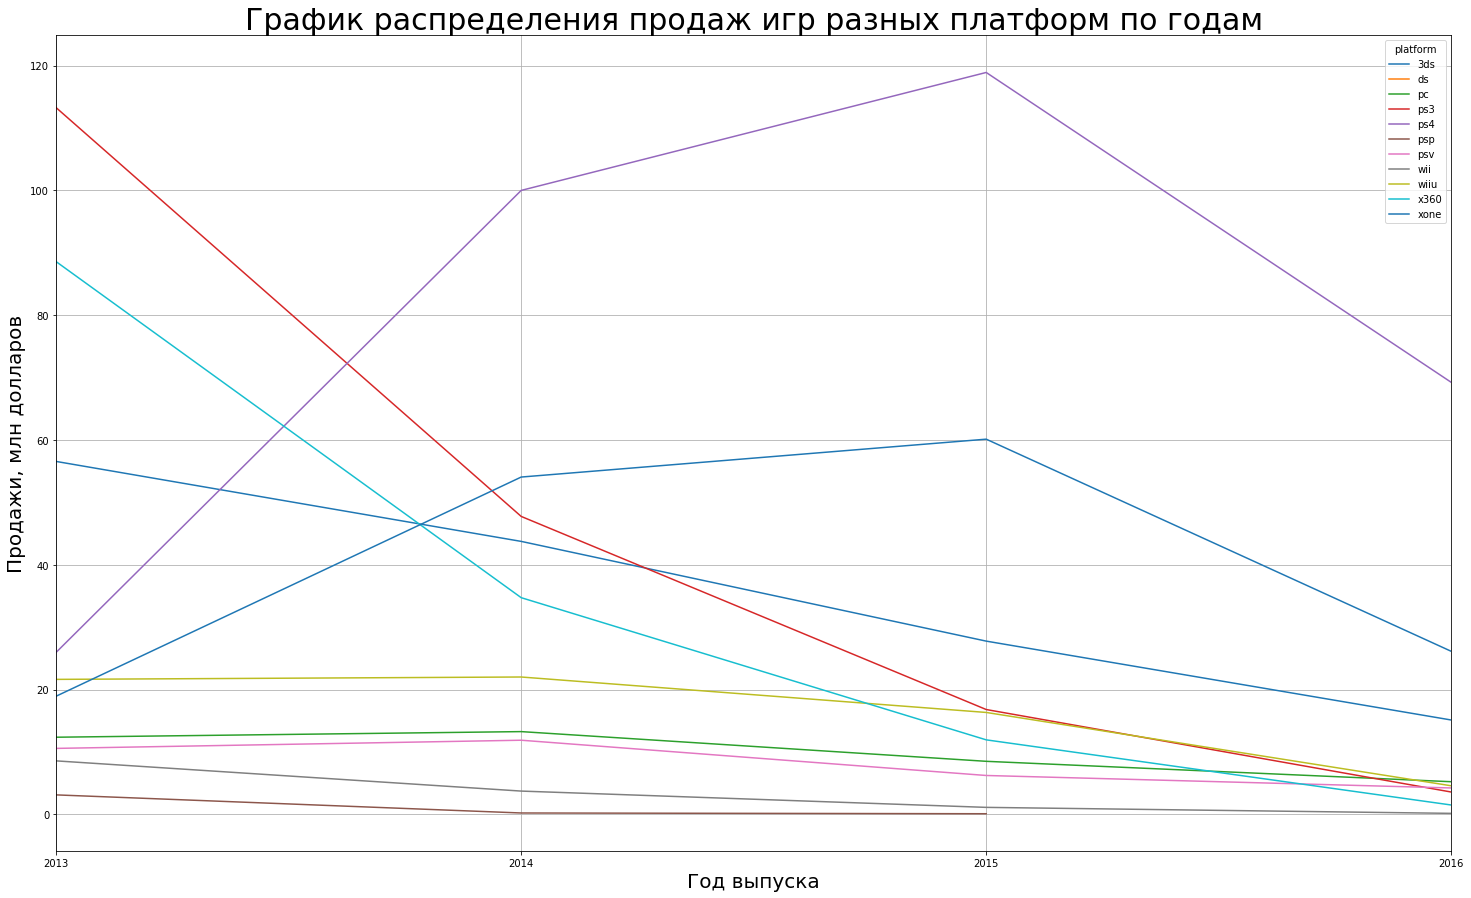

In [29]:
fig, ax=plt.subplots(figsize=(25,15))
relevant_data.pivot_table(index='year_of_release',
                                columns='platform', 
                                values='total_sales', 
                                aggfunc='sum').plot(grid=True, ax=ax)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_xlabel('Год выпуска', fontsize = 20);
ax.set_ylabel('Продажи, млн долларов', fontsize = 20);
ax.set_title('График распределения продаж игр разных платформ по годам', fontsize = 30);
plt.show()

In [30]:
relevant_data.pivot_table(index='platform',
                                values='total_sales', 
                                aggfunc='sum').sort_values(by='total_sales', ascending=False).T

platform,ps4,ps3,xone,3ds,x360,wiiu,pc,psv,wii,psp,ds
total_sales,314.14,181.43,159.32,143.25,136.8,64.63,39.43,32.99,13.66,3.5,1.54


Исходя из графика, можно сдлеать следующие выводы:
- когда появились платформы ps4 и xone начали падать продажи платформ-лидеров предыдущих 10 лет - ps3 и x360. 
- продажи всех платформ упали за период 2015-2016 гг;
- среди всех платформ можно выделить ps4 и xone как потенциально прибыльные, так как они имеют наибольшую сумму продаж за последние 3 года;

#### 5. Построим график «ящик с усами» по глобальным продажам игр в разбивке по платформам и опишем полученный результат.

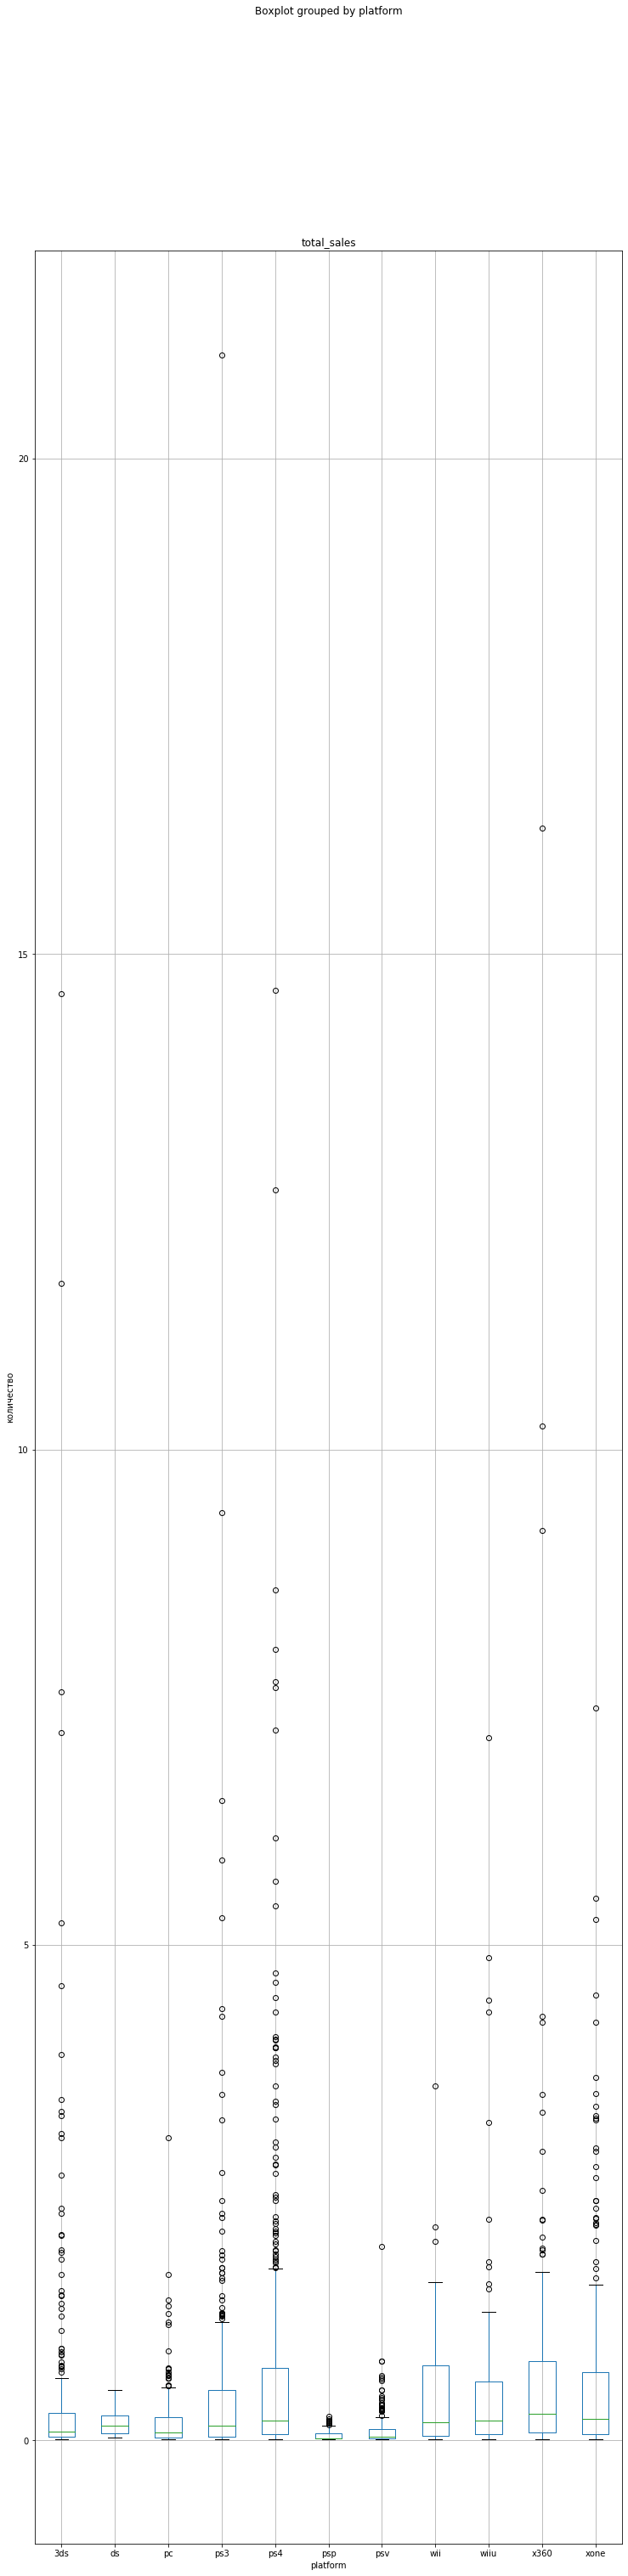

In [31]:
fig, ax = plt.subplots(figsize = (12, 50))
relevant_data.boxplot(column='total_sales', by='platform', ax = ax);
ax.set_ylabel('количество')
plt.show()

Исходя из графика можно сделать следующие выводы:
- медианные продажи каждой игры во всех платформах практически одинаковые и маленькие - меньше 0,5 млн;
- для всех платформ верхний ус больше нижнего и практически везде есть много выбросов выше верхнего уса. Исходя из этого и предыдущего пункта, можно сказать, что на каждой платформе выпускается огромное количество игр с невысокими продажами и небольшое количество игр-бестселлеров - они и являются выбросами на графике и приносят огромную прибыль.
- на платформе ps3 выходила игра с самыми большими продажами среди всех платформ - более 20млн долларов. 
- больше всего игр-бестселлеров выходило на платформе ps4, следом идет x360;
- наименее прибыльные платформы - это ds и psp;
Общий вывод:
- каждый год на каждой платформе выходит огромное количество игр, но только малое количество из них становится бестселлерами и лидерами продаж.

#### 6. Посмотрим, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Построим диаграмму рассеяния и посчитаем корреляцию между отзывами и продажами. 

Рассмотрим платформу ps4, так как у нее наибольшие суммарные продажи и на ней выходило множество бестселлеров. Выделим данные о платформе в отдельный датафрейм.

In [32]:
ps4_data = relevant_data.query('platform == "ps4"')
ps4_data

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
31,call of duty: black ops 3,ps4,2015,shooter,6.03,5.86,0.36,2.38,NaN,NaN,NaN,14.63
42,grand theft auto v,ps4,2014,action,3.96,6.31,0.38,1.97,97.0,83.0,M,12.62
77,fifa 16,ps4,2015,sports,1.12,6.12,0.06,1.28,82.0,43.0,E,8.58
87,star wars battlefront (2015),ps4,2015,shooter,2.99,3.49,0.22,1.28,NaN,NaN,NaN,7.98
92,call of duty: advanced warfare,ps4,2014,shooter,2.81,3.48,0.14,1.23,83.0,57.0,M,7.66
...,...,...,...,...,...,...,...,...,...,...,...,...
16500,root letter,ps4,2016,adventure,0.00,0.00,0.01,0.00,69.0,75.0,NaN,0.01
16503,shin hayarigami 2,ps4,2016,adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01
16526,dungeons 2,ps4,2016,role-playing,0.01,0.00,0.00,0.00,61.0,79.0,T,0.01
16530,carmageddon: max damage,ps4,2016,action,0.01,0.00,0.00,0.00,51.0,55.0,M,0.01


Построим диаграмму рассеяния и посчитаем корреляцию между отзывами и продажами.

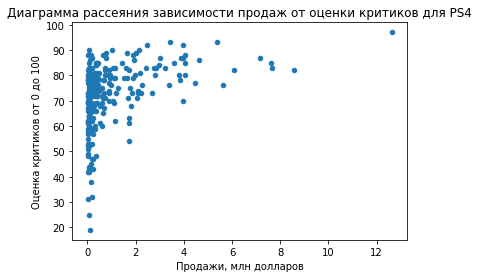

In [33]:
ax = ps4_data.plot(x='total_sales',y='critic_score',kind='scatter')
ax.set_xlabel('Продажи, млн долларов');
ax.set_ylabel('Оценка критиков от 0 до 100');
ax.set_title('Диаграмма рассеяния зависимости продаж от оценки критиков для PS4');

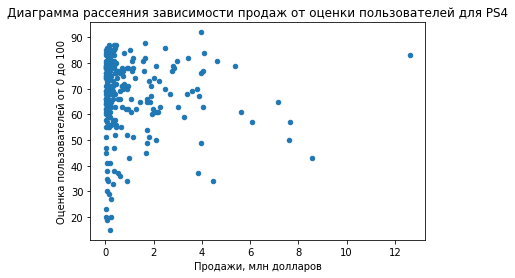

In [34]:
ax = ps4_data.plot(x='total_sales',y='user_score',kind='scatter')
ax.set_xlabel('Продажи, млн долларов');
ax.set_ylabel('Оценка пользователей от 0 до 100');
ax.set_title('Диаграмма рассеяния зависимости продаж от оценки пользователей для PS4');

In [35]:
ps4_data['total_sales'].corr(ps4_data['critic_score'])

0.406567902061781

In [36]:
ps4_data['total_sales'].corr(ps4_data['user_score'])

-0.031957110204556445

Вывод для игр платформы ps4:
- есть слабая корреляция между продажами и рейтингом критиков;
- нет корреляции между продажами и рейтингом пользователейю

#### 7. Соотнесем выводы с продажами игр на других платформах.

Выделим остальные игры в отдельный датафрейм. Построим диаграмму рассеяния и посчитаем корреляцию между отзывами и продажами.

In [37]:
rest_games = relevant_data.query('platform != "ps4"')

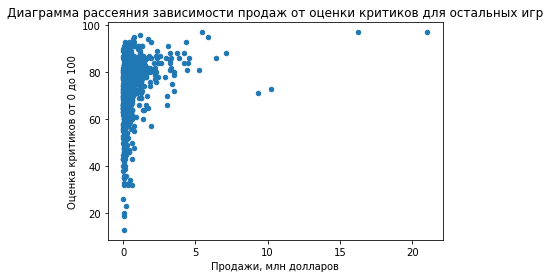

In [38]:
ax = rest_games.plot(x='total_sales',y='critic_score',kind='scatter')
ax.set_xlabel('Продажи, млн долларов');
ax.set_ylabel('Оценка критиков от 0 до 100');
ax.set_title('Диаграмма рассеяния зависимости продаж от оценки критиков для остальных игр');

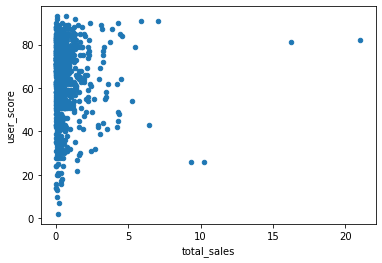

In [39]:
rest_games.plot(x='total_sales',y='user_score',kind='scatter')
ax.set_xlabel('Продажи, млн долларов');
ax.set_ylabel('Оценка пользователей от 0 до 100');
ax.set_title('Диаграмма рассеяния зависимости продаж от оценки пользователей для остальных платформ');

In [40]:
rest_games['total_sales'].corr(rest_games['critic_score'])

0.2812510848217569

In [41]:
rest_games['total_sales'].corr(rest_games['user_score'])

-0.001121624209337847

Вывод для игр всех остальных платформ:
- есть очень слабая корреляция между продажами и рейтингом критиков;
- нет корреляции между продажами и рейтингом пользователейю

#### Общий вывод: 
- продажи игр всех платформ не зависят от рейтингов пользователей;
- корреляция между оценкой критиков и продажами платформы-лидера ps4 немного выше, чем корреляция между оценкой критиков и продажами всех остальных платформ. Возможная причина - у игр платформы-лидера больше оценок критиков и пользователи им доверяют больше. 

#### 8. Посмотрим на общее распределение игр по жанрам. Ответим на вопросы:
- Что можно сказать о самых прибыльных жанрах? 
- Выделяются ли жанры с высокими и низкими продажами?

Для начала посмотрим, количество игр, выпущенных в каждом жанре.

In [42]:
relevant_data['genre'].value_counts()

action          766
role-playing    292
adventure       245
sports          214
shooter         187
misc            155
racing           85
fighting         80
platform         74
simulation       62
strategy         56
puzzle           17
Name: genre, dtype: int64

Видим, что жанр с самыми большими суммарными - экшн, обгонящий вторую строчку более чем в 2 раза. Далее идут ролевые игры и квесты. Самый непродаваемый жанр - паззл.

Теперь посмотрим, как распределяются продажи по жанрам. Представим данные в сводной таблице и построим столбчатую диаграмму глобальных продаж игр по жанрам.

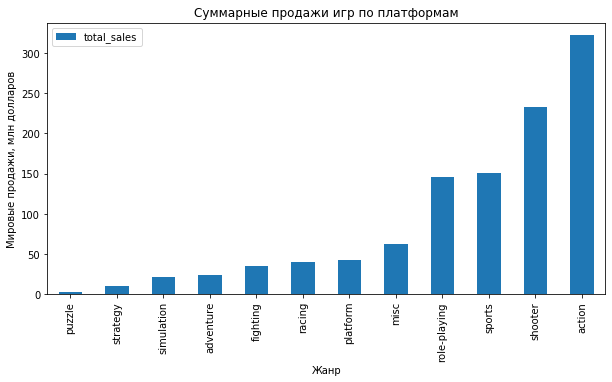

In [43]:
ax = (relevant_data.pivot_table(index='genre', values='total_sales', aggfunc='sum')
 .sort_values(by='total_sales').plot(kind='bar', y='total_sales', figsize=(10,5), 
                                     title='Суммарные продажи игр по платформам'))
ax.set_xlabel('Жанр');
ax.set_ylabel('Мировые продажи, млн долларов');

Мы нашли жанры-лидеры по суммарным продажам. Теперь посмотрим, сколько в среднем денег приносит одна выпускаемая игра каждого жанра. Найдем и среднее и медианное значения.

In [44]:
relevant_data.pivot_table(index='genre', values='total_sales', aggfunc=['mean', 'median'])

,mean,median
,total_sales,total_sales
genre,,
action,0.420196,0.110
adventure,0.096490,0.030
fighting,0.441375,0.125
misc,0.405290,0.100
platform,0.576081,0.225
puzzle,0.186471,0.060
racing,0.469294,0.120
role-playing,0.499623,0.125


Исходя из этой таблицы, можно сделать следующие выводы:
1. Для всех жанров значительно отличаются значения среднего и медианы. Это говорит о том, что есть большое количество игр с маленькими продажами и малое количество игр-бестселлеров, дающих гигантские продажи.
2. Самый прибыльный жанр - шутер. В среднем, игра в этом жанре приносит 1.25 млн долларов. Далее идут спортивные игры и платформеры с 0.7 и 0.58 млн долларов соответственно. Самый низкоприбыльный жанр - квесты с их средними 0.1 млн долларов от игры.

#### Общий вывод:
В целом, можно сказать, что есть 2 стратегии по производству игр по жанрам: можно производить огромное количество игр в жанре экшн и заработать на этом много денег, либо выбрать более прибыльный жанр шутер и производить значительно меньше игр, но каждая игра будет приносить большую прибыль.

### Общий вывод шага 3:

#### 1. Количество выпускаемых игр по годам:
- до 1994 года выпускалось очень мало игр;
- в 2002 году был резкий скачок в производстве игр и до 2009 года количество выпускаемых игр практически всегда росло;
- в 2010 году начался спад в производстве игр и продолжался он до 2016 года.
- в период 2012-2016 год продажи игр значительно упали по сравнению с предшествующим 4-летним периодом. 
#### 2. Самые популярные платформы и срок жизни платформы:
- самыми популярными платформами являются ps2, x360, ps3, wii
- средний срок жизнти платформы - 10 лет. 
#### 3. Актуальный период для построения прогноза на 2017 год - это период 2013-2016 год, так как в 2013 году вышли платформы-лидеры ps4 и xone
#### 4. Потенциально прибыльные платформы:
- когда появились платформы ps4 и xone начали падать продажи платформ-лидеров предыдущих 10 лет - ps3 и x360.
- продажи всех платформ упали за период 2015-2016 гг;
- среди всех платформ можно выделить ps4 и xone как потенциально прибыльные, так как они имеют наибольшую сумму продаж за последние 3 года;
#### 5. Распределение продаж по игрым:
- на платформе ps3 выходила игра с самыми большими продажами среди всех платформ - более 20млн долларов. 
- больше всего игр-бестселлеров выходило на платформе ps4, следом идет x360;
- наименее прибыльные платформы - это ds и psp;
- каждый год на каждой платформе выходит огромное количество игр, но только малое количество из них становится бестселлерами и лидерами продаж, и именно эти игры приносят гигансткие деньги.
#### 6. Влияние отзывов критиков и пользователей на продажи:
- продажи игр всех платформ не зависят от рейтингов пользователей;
- корреляция между оценкой критиков и продажами платформы-лидера ps4 немного выше, чем корреляция между оценкой критиков и продажами всех остальных платформ. Возможная причина - у игр платформы-лидера больше оценок критиков и пользователи им доверяют больше. 
#### 7. Прибыльность жанров:
- самый прибыльный жанр - шутер. В среднем, игра в этом жанре приносит 1.25 млн долларов. Далее идут спортивные игры и платформеры с 0.7 и 0.58 млн долларов соответственно. Самый низкоприбыльный жанр - квесты с их средними 0.1 млн долларов от игры.
- жанр с самыми большими суммарными - экшн, обгонящий вторую строчку более чем в 2 раза. Далее идут ролевые игры и квесты. Самый непродаваемый жанр - паззл.
- в целом, можно сказать, что есть 2 стратегии по производству игр по жанрам: можно производить огромное количество игр в жанре экшн и заработать на этом много денег, либо выбрать более прибыльный жанр шутер и производить значительно меньше игр, но каждая игра будет приносить большую прибыль.

# Шаг 4. Портрет пользователя каждого региона.

#### 1. Определим для пользователя каждого региона (NA, EU, JP) самые популярные платформы (топ-5). Опишем различия в долях продаж.

Сначала создадим список значений с суммами продаж по регионам.

In [45]:
sales = ['na_sales', 'eu_sales', 'jp_sales']

Построим график распределения продаж по платформам в процентном соотношении, предварительно сгруппировав данные с помощью сводной таблицы и взяв 5 самых продаваемых платформ. В цикле пройдемся по продажам в разных регионах, таким образом, получим 3 графика.

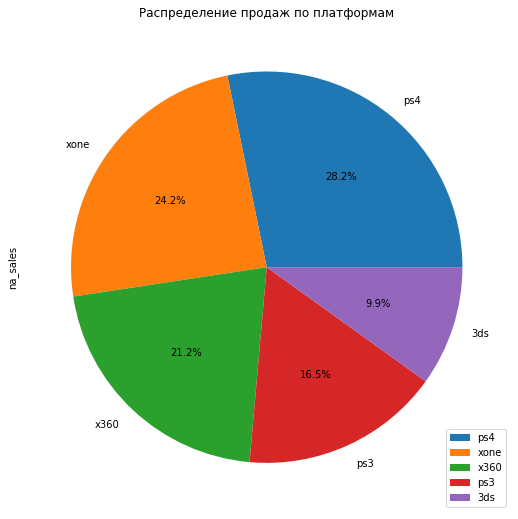

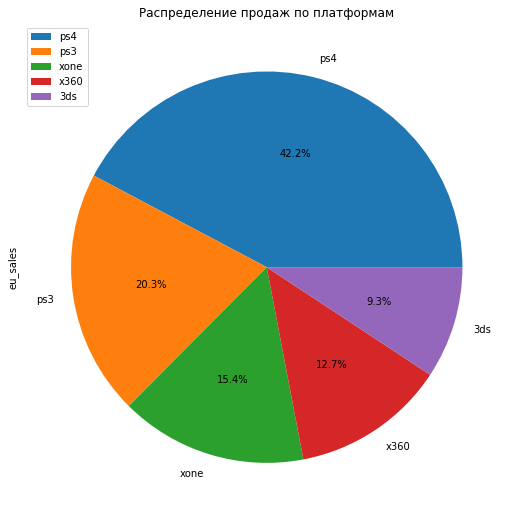

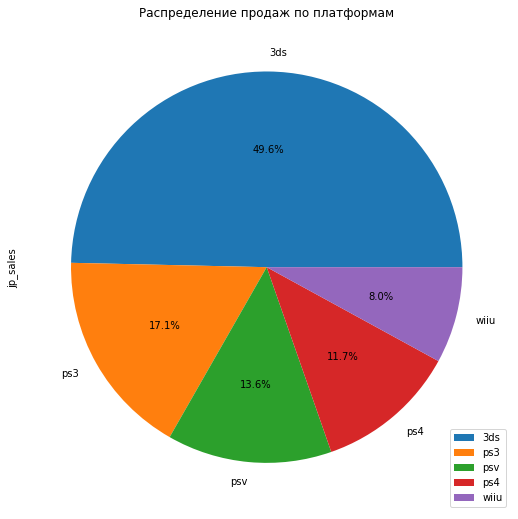

In [46]:
for sale in sales:
    (relevant_data
                   .pivot_table(index='platform', values=sale, aggfunc='sum')
                   .sort_values(by=sale, ascending=False)
                   .head(5)
                   .plot(kind='pie', y=sale, autopct='%1.1f%%', 
                         figsize=(9,9), title='Распределение продаж по платформам'))

#### Описание пользователя каждого региона в разрезе платформ:
1. В Северной Америке практически одинаково популярны консоли Xbox и Playstation - они занимают почти 90% среди топ-5 платформ. Портативной Nintendo 3ds досталось лишь меньше 10%. Самая популярная платформа - PS4 (28.2%), далее идут Xone (24.2%) и X360 (21.2%)
2. Жители Европы отдают предпочтение консоли Playstation - в сумме платформы PS4 и PS3 занимают большк 60% среди топ-5 платформ. На втором месте - Xbox (28.1%), далее идет Nintendo 3ds(9.3%). Самая популярная платформа - PS4 (42.2%), далее идет PS3 (20.3%), тройку лидеров закрывает Xone (15.4%).
3. В Японии безоговорочным лидером является Nintendo 3ds- почти 50% из топ-5. Япония - единственный регион, где лидирует портативная приставка, а не стационарная. Причем в Японии еще остается популярной платформа Wiiu (8%), не вошедшая в пятерку лидеров в других регионах, а также популярна портативная Psv (13.6%).  Playstation досталось только меньше 30% рынка - PS3 (17.1%) и PS4 (11.7%). В пятерку идеров не вошел Xbox.
#### Общий вывод:
Рынки продаж Японии, Северной Америки и Европы значительно отличаются. В Японии популярнее всего портативные приставки Nintendo 3ds, в Европе - стационарная PS4, а в Северной Америке почти одинаково популярны PS4 и Xone. Стоит отметить, что японский рынок кардинально отличется от остальных - там преобладают портативные приставки, во остальных рынках - стационарные консоли. Эти особенности обязательно необходимо учитывать при планировании концепции продаж и рекламной кампании на 2017 год. Общая рекомендация: кампании продаж и рекламы относительно игровых платформ должны быть разными для всех трех регионов - в Японии стоит сосредоточиться на играх для портативных приставок Nintendo 3ds, в Европе -  на PS4, в Северной Америке стоит уделить одинаковое внимание на PS4 и Xone.

#### 2. Определим для пользователя каждого региона (NA, EU, JP) самые популярные жанры (топ-5). 

Построим график распределения продаж по жанрам в процентном соотношении, предварительно сгруппировав данные с помощью сводной таблицы и взяв 5 самых продаваемых жанров. В цикле пройдемся по продажам в разных регионах, таким образом, получим 3 графика.

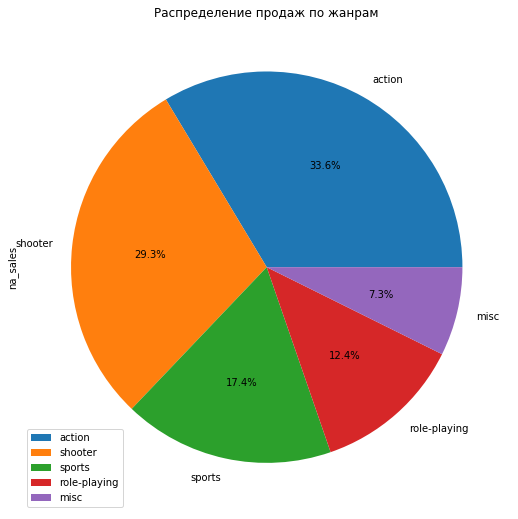

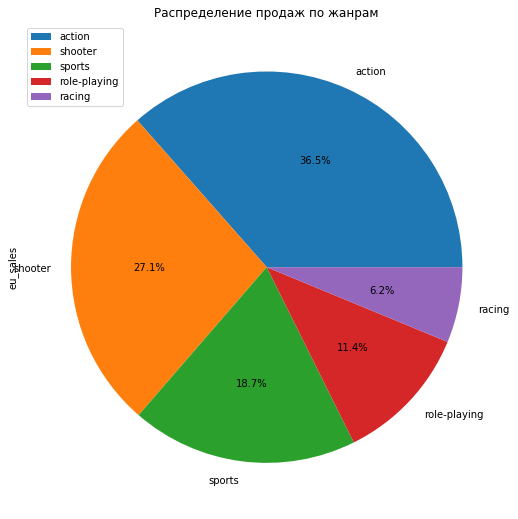

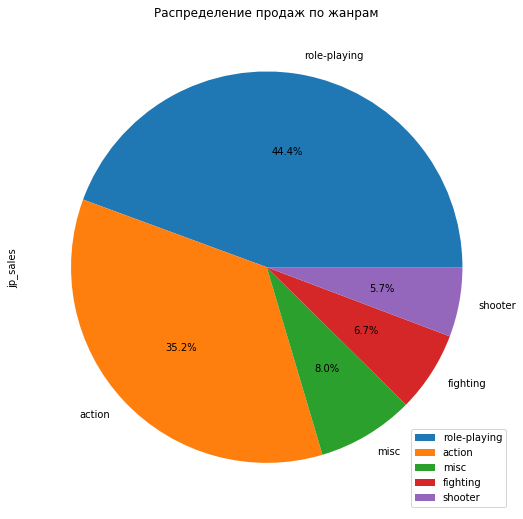

In [47]:
for sale in sales:
    (relevant_data
                   .pivot_table(index='genre', values=sale, aggfunc='sum')
                   .sort_values(by=sale, ascending=False)
                   .head(5)
                   .plot(kind='pie', y=sale, autopct='%1.1f%%', 
                         figsize=(9,9), title='Распределение продаж по жанрам'))

#### Описание пользователя каждого региона в разрезе жанров:
1. В Северной Америке популярнее всего жанр экшн (33.6%), следом с небольшим отставанием идет жанр шутер (29.3%), а тройку лидеров закрывает жанр спортивных игры (17.4%). 
2. В Европе лидером является жанр экшн (36.5%), второй - шутер (27.1%), следом идут спортивные игры (18.7%).
3. Японские геймеры отдают предпочтение ролевым играм (44.4%), на втором месте игры в жанре экшн (35.2%). Игры в жанре шутер, так популярные в Северной Америке и Европе, на японском рынке закрывают пятерку лидеров с долей 5.7%.
#### Общий вывод.
Рынки продаж Северной Америки и Европы очень похожи - у них одинаковая тройка жанров-лидеров с очень похожей долей каждого: экшн, шутер, спортивные игры. А вот японский рынок игр - это совершенно другой мир. Значительная часть геймеров страны восходящего солнца предпочитают играть в ролевые игры, меньше - в игры в жанре экшн. Но если ориентироваться на долю жанра среди топ-5, то экшн-игры занимают около 35% во всех трех регионах. ТАкже стоит заметить, что шутеры, столько популярные в Северной Америке и Европе, не сильно любимы японцами. Общая рекомендация: кампании продаж и рекламы относительно жанров необходимо разделить на 2 части: Япония и Европа + Северная Америка. В Японии стоит сделать упор на ролевые игры6 в остальных регионах - на игры в жанре экшн.

#### 3. Определим для пользователя каждого региона (NA, EU, JP), влияет ли рейтинг ESRB на продажи в отдельном регионе.

Для начала посмотрим, какие значения рейтинга бывают.

In [48]:
relevant_data['rating'].value_counts()

M       369
T       333
E       302
E10+    252
Name: rating, dtype: int64

У нас есть 4 значения рейтинга:
- М - для взрослых
- Т - для подростков
- Е - для всех
- Е10+ - для всех от 10 лет и старше

В цикле с помощью сводной таблицу найдем среднее значение продаж по каждому региону в зависимости от рейтинга.

In [49]:
for sale in sales:
    display(relevant_data.pivot_table(index='rating', values=sale, aggfunc='mean'))  

,na_sales
rating,
E,0.261755
E10+,0.215238
M,0.447724
T,0.149520


,eu_sales
rating,
E,0.276026
E10+,0.169405
M,0.393821
T,0.125976


,jp_sales
rating,
E,0.050132
E10+,0.023373
M,0.038238
T,0.061832


Мы видим, что в среднем в Европе и Северной Америке больше всего денег приносят игры для взрослых, в Японии - игры для тинейджеров.
Но этих данных недостаточно, чтобы сказать, есть ли зависимость между рейтингом игры и продажами.
Чтобы найти зависимость рейтинга и продаж создадим новый столбце с рейтингом, в котором каждому рейтингу будет соотвествовать определенная цифра. Также построим диаграмму рассеяния.

In [50]:
dict =({'E':0,'E10+':1,'T':2,'M':3})
relevant_data['rating_int'] = relevant_data['rating'].map(dict)

In [51]:
for sale in sales:
    print('Корреляция рейтинга игры и продаж для региона', sale, 'равна {:.2f}'
          .format(relevant_data[sale].corr(relevant_data['rating_int'])))

Корреляция рейтинга игры и продаж для региона na_sales равна 0.10
Корреляция рейтинга игры и продаж для региона eu_sales равна 0.07
Корреляция рейтинга игры и продаж для региона jp_sales равна -0.00


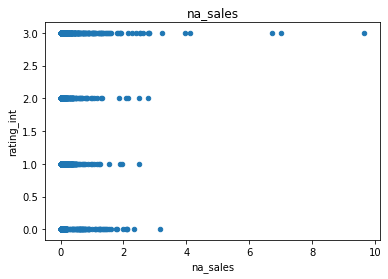

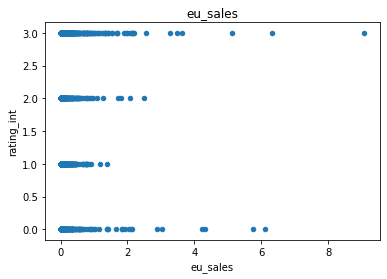

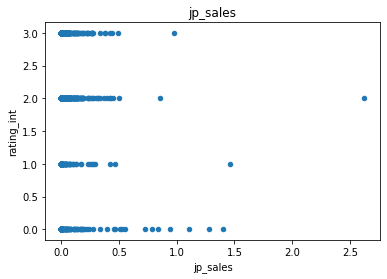

In [52]:
for sale in sales:
    relevant_data.plot(x=sale,y='rating_int',kind='scatter', title=sale)

#### Вывод о зависимости продаж игры от рейтинга:
В Европе и Японии продажи игр не зависят от рейтинга. В Северной Америке есть очень слабая зивисимость. На диаграммах рассеяния мы видим, что продажи большинства игр сосредоточены в диапазоне до 2млн долларов в Европе и Америке и до 0.5 млн долларов в Японии вне зависимоти от рейтинга игр.

### Вывод 4 шага:
#### 1. Описание пользователя каждого региона в разрезе платформ:
- Рынки продаж Японии, Северной Америки и Европы значительно отличаются. В Японии популярнее всего портативные приставки Nintendo 3ds, в Европе - стационарная PS4, а в Северной Америке почти одинаково популярны PS4 и Xone. Стоит отметить, что японский рынок кардинально отличется от остальных - там преобладают портативные приставки, во остальных рынках - стационарные консоли. Эти особенности обязательно необходимо учитывать при планировании концепции продаж и рекламной кампании на 2017 год. Общая рекомендация: кампании продаж и рекламы относительно игровых платформ должны быть разными для всех трех регионов - в Японии стоит сосредоточиться на играх для портативных приставок Nintendo 3ds, в Европе -  на PS4, в Северной Америке стоит уделить одинаковое внимание на PS4 и Xone.
#### 2. Описание пользователя каждого региона в разрезе жанров:
- Рынки продаж Северной Америки и Европы очень похожи - у них одинаковая тройка жанров-лидеров с очень похожей долей каждого: экшн, шутер, спортивные игры. А вот японский рынок игр - это совершенно другой мир. Значительная часть геймеров страны восходящего солнца предпочитают играть в ролевые игры, меньше - в игры в жанре экшн. Но если ориентироваться на долю жанра среди топ-5, то экшн-игры занимают около 35% во всех трех регионах. ТАкже стоит заметить, что шутеры, столько популярные в Северной Америке и Европе, не сильно любимы японцами. Общая рекомендация: кампании продаж и рекламы относительно жанров необходимо разделить на 2 части: Япония и Европа + Северная Америка. В Японии стоит сделать упор на ролевые игры6 в остальных регионах - на игры в жанре экшн.
#### 3. Зависимость продаж игр от рейтинга для каждого региона:
- В Европе и Японии продажи игр не зависят от рейтинга. В Северной Америке есть очень слабая зивисимость. На диаграммах рассеяния мы видим, что продажи большинства игр сосредоточены в диапазоне до 2млн долларов в Европе и Америке и до 0.5 млн долларов в Японии вне зависимоти от рейтинга игр.
#### 4. Объем рынка:
- Рынки Северной Америки и Европы "дороже" рынка Японии и проносят больше денег. Рекомендация: при планировании кампании продаж и рекламы учитывать этот фактор и Европе и Америке отдавать большую долю бюджета, чем Японии.

# Шаг 5. Проверка гипотез.

#### 1. Проверим гипотезу "Средние пользовательские рейтинги платформ Xbox One и PC одинаковые".

Так как нулевая гипотеза всегда формулируется так, чтобы использовать знак равенства, нулевая и альтернативная гипотезы будут выглядеть следующим образом:
- 𝐻0: Средние пользовательские рейтинги платформ Xbox One и PC равны
- 𝐻1: Средние пользовательские рейтинги платформ Xbox One и PC не равны

Значение альфа задам равное 0.05, то есть нулевая гипотеза отвергается при значении p-value <  𝛼=0.05. Используем критерий Стьюдента для сравнения средних значений каждой из выборок, так как эти выборки независимы друг от друга.

In [53]:
alpha = 0.05
result = st.ttest_ind(relevant_data[relevant_data['platform'] == 'xone']['user_score'], 
                      relevant_data[relevant_data['platform'] == 'pc']['user_score'], 
                     nan_policy="omit")
print('p-значение:', result.pvalue)

if (result.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.1401265840361139
Не получилось отвергнуть нулевую гипотезу


#### В результате, нам не удалось отвергнуть нулевую гипотезу, заключающуюся в том, что Средние пользовательские рейтинги платформ Xbox One и PC равны.

#### 2. Проверим гипотезу "Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные".

Так как нулевая гипотеза всегда формулируется так, чтобы использовать знак равенства, нулевая и альтернативная гипотезы будут выглядеть следующим образом:
- 𝐻0: Средние пользовательские рейтинги жанров Action и Sports равны
- 𝐻1: Средние пользовательские рейтинги жанров Action и Sports не равны

Значение альфа задам равное 0.05, то есть нулевая гипотеза отвергается при значении p-value <  𝛼=0.05. Используем критерий Стьюдента для сравнения средних значений каждой из выборок, так как эти выборки независимы друг от друга.

In [54]:
result_1 = st.ttest_ind(relevant_data[relevant_data['genre'] == 'action']['user_score'], 
                      relevant_data[relevant_data['genre'] == 'sports']['user_score'], 
                     nan_policy="omit")
print('p-значение:', result_1.pvalue)

if (result_1.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 1.0517832389143492e-27
Отвергаем нулевую гипотезу


#### В результате, мы отвергаем нулевую гипотезу, заключающуюся в том, что Средние пользовательские рейтинги жанров Action и Sports равны.

### Вывод 4 шага:
#### С помощью критерия Стьюдента мы сравнили средние рейтинги и пришли к следующим выводам:
- нам не удалось отвергнуть гипотезу, заключающуюся в том, что Средние пользовательские рейтинги платформ Xbox One и PC равны.
- мы отвергли гипотезу, заключающуюся в том, что Средние пользовательские рейтинги жанров Action и Sports равны.

# Шаг 6. Общий вывод.

## I. Чистота и полнота данных.
- в данных об отзывах и рейтинге было обнаружено много пропусков. Это проблема, которой стоит избежать в будущем. Возможно, есть какие-либо ошибки в выгрузки данных. Этот вопрос необходимо исследовать и устранить неполадки.
- мы не заполняли пропуски в данных, так как у нас недостаточно информации, чобы заполнить эти пропуски корректно. Анализ был выполнен на основании выгруженных корректно данных.
## II. Исследовательский анализ данных.
#### В результате исследовательского анализа данных, мы пришли к ряду заключений:
#### 1. Количество выпускаемых игр по годам:
- до 1994 года выпускалось очень мало игр;
- в 2002 году был резкий скачок в производстве игр и до 2009 года количество выпускаемых игр практически всегда росло;
- в 2010 году начался спад в производстве игр и продолжался он до 2016 года.
- в период 2012-2016 год продажи игр значительно упали по сравнению с предшествующим 4-летним периодом. 
#### 2. Самые популярные платформы и срок жизни платформы:
- самыми популярными платформами являются ps2, x360, ps3, wii
- средний срок жизнти платформы - 10 лет. 
#### 3. Актуальный период для построения прогноза на 2017 год - это период 2013-2016 год, так как в 2013 году вышли платформы-лидеры ps4 и xone
#### 4. Потенциально прибыльные платформы:
- когда появились платформы ps4 и xone начали падать продажи платформ-лидеров предыдущих 10 лет - ps3 и x360.
- продажи всех платформ упали за период 2015-2016 гг;
- среди всех платформ можно выделить ps4 и xone как потенциально прибыльные, так как они имеют наибольшую сумму продаж за последние 3 года;
#### 5. Распределение продаж по игрым:
- на платформе ps3 выходила игра с самыми большими продажами среди всех платформ - более 20млн долларов. 
- больше всего игр-бестселлеров выходило на платформе ps4, следом идет x360;
- наименее прибыльные платформы - это ds и psp;
- каждый год на каждой платформе выходит огромное количество игр, но только малое количество из них становится бестселлерами и лидерами продаж, и именно эти игры приносят гигансткие деньги.
#### 6. Влияние отзывов критиков и пользователей на продажи:
- продажи игр всех платформ не зависят от рейтингов пользователей;
- корреляция между оценкой критиков и продажами платформы-лидера ps4 немного выше, чем корреляция между оценкой критиков и продажами всех остальных платформ. Возможная причина - у игр платформы-лидера больше оценок критиков и пользователи им доверяют больше. 
#### 7. Прибыльность жанров:
- самый прибыльный жанр - шутер. В среднем, игра в этом жанре приносит 1.25 млн долларов. Далее идут спортивные игры и платформеры с 0.7 и 0.58 млн долларов соответственно. Самый низкоприбыльный жанр - квесты с их средними 0.1 млн долларов от игры.
- жанр с самыми большими суммарными - экшн, обгонящий вторую строчку более чем в 2 раза. Далее идут ролевые игры и квесты. Самый непродаваемый жанр - паззл.
- в целом, можно сказать, что есть 2 стратегии по производству игр по жанрам: можно производить огромное количество игр в жанре экшн и заработать на этом много денег, либо выбрать более прибыльный жанр шутер и производить значительно меньше игр, но каждая игра будет приносить большую прибыль.
## III. Портрет пользователя каждого региона.
#### Мы рассмотрели продажи игр в трех регионах - Северной Америке, Европе и Японии и пришли к ряду выводов:
#### 1. Описание пользователя каждого региона в разрезе платформ:
- Рынки продаж Японии, Северной Америки и Европы значительно отличаются. В Японии популярнее всего портативные приставки Nintendo 3ds, в Европе - стационарная PS4, а в Северной Америке почти одинаково популярны PS4 и Xone. Стоит отметить, что японский рынок кардинально отличется от остальных - там преобладают портативные приставки, во остальных рынках - стационарные консоли. Эти особенности обязательно необходимо учитывать при планировании концепции продаж и рекламной кампании на 2017 год. Общая рекомендация: кампании продаж и рекламы относительно игровых платформ должны быть разными для всех трех регионов - в Японии стоит сосредоточиться на играх для портативных приставок Nintendo 3ds, в Европе -  на PS4, в Северной Америке стоит уделить одинаковое внимание на PS4 и Xone.
#### 2. Описание пользователя каждого региона в разрезе жанров:
- Рынки продаж Северной Америки и Европы очень похожи - у них одинаковая тройка жанров-лидеров с очень похожей долей каждого: экшн, шутер, спортивные игры. А вот японский рынок игр - это совершенно другой мир. Значительная часть геймеров страны восходящего солнца предпочитают играть в ролевые игры, меньше - в игры в жанре экшн. Но если ориентироваться на долю жанра среди топ-5, то экшн-игры занимают около 35% во всех трех регионах. ТАкже стоит заметить, что шутеры, столько популярные в Северной Америке и Европе, не сильно любимы японцами. Общая рекомендация: кампании продаж и рекламы относительно жанров необходимо разделить на 2 части: Япония и Европа + Северная Америка. В Японии стоит сделать упор на ролевые игры6 в остальных регионах - на игры в жанре экшн.
#### 3. Зависимость продаж игр от рейтинга для каждого региона:
- В Европе и Японии продажи игр не зависят от рейтинга. В Северной Америке есть очень слабая зивисимость. На диаграммах рассеяния мы видим, что продажи большинства игр сосредоточены в диапазоне до 2млн долларов в Европе и Америке и до 0.5 млн долларов в Японии вне зависимоти от рейтинга игр.
#### 4. Объем рынка:
- Рынки Северной Америки и Европы "дороже" рынка Японии и проносят больше денег. Рекомендация: при планировании кампании продаж и рекламы учитывать этот фактор и Европе и Америке отдавать большую долю бюджета, чем Японии.
## IV. Проверка гипотез.
#### С помощью критерия Стьюдента мы сравнили средние рейтинги и пришли к следующим выводам:
- нам не удалось отвергнуть гипотезу, заключающуюся в том, что Средние пользовательские рейтинги платформ Xbox One и PC равны.
- мы отвергли гипотезу, заключающуюся в том, что Средние пользовательские рейтинги жанров Action и Sports равны.